In [1]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# ---------------------------------------------------------------------------------
%matplotlib inline
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# =================================================================================
# SECTION 1.2: CONFIGURATION CLASS (FOR EMA WEIGHT TRANSFER)
# =================================================================================
class Config:
    # --- Data Paths and Domains ---
    DATA_DIR = r"D:\Salaar Masood\pacs-dataset\pacs_data"
    DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
    
    # --- Model & Architecture ---
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 7
    NUM_HEADS = 4
    DROPOUT_OPTIONS = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    ### NEW: EMA Hyperparameter ###
    # Controls how much of the old student weights to keep. 0.999 is a common value.
    EMA_DECAY = 0.999
    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 20 # Train longer to let the EMA stabilize
    LEARNING_RATE = 1e-4
    OPTIMIZER = "AdamW"
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

print("--- Project Configuration (EMA Weight Transfer) ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("---------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2.")

--- Project Configuration (EMA Weight Transfer) ---
DATA_DIR: D:\Salaar Masood\pacs-dataset\pacs_data
DOMAINS: ['art_painting', 'cartoon', 'photo', 'sketch']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 7
NUM_HEADS: 4
DROPOUT_OPTIONS: [0.3, 0.4, 0.5, 0.6, 0.7]
EMA_DECAY: 0.999
BATCH_SIZE: 128
NUM_EPOCHS: 20
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
---------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2.


In [3]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING
# =================================================================================

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# Define the transformations for training (with augmentation) and validation/testing.
# ---------------------------------------------------------------------------------

# The ViT model was pre-trained on images of size 224x224
IMG_SIZE = 224

# The normalization values are standard for many pre-trained models
# but it's good practice to use the ones specified by the model's authors if available.
# For ViT, a simple (0.5, 0.5, 0.5) normalization is common.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # A simple data augmentation technique
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


In [4]:
# ---------------------------------------------------------------------------------
# 2.2: CUSTOM PACS DATASET CLASS
# This class will read the images and labels from our specific folder structure.
# ---------------------------------------------------------------------------------
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        """
        Args:
            root_dir (string): Directory with all the domain folders.
            domains (list of string): List of domains to include in this dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Discover all classes (dog, elephant, etc.) and map them to integers
        self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Load image paths and labels from the specified domains
        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                for img_name in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = PACSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [6]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE (EMA WEIGHT TRANSFER)
# =================================================================================

class DistillationViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rates: list, dummy_dropout_rate: float):
        super(DistillationViT, self).__init__()
        
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        hidden_dim = self.vit_backbone.config.hidden_size
        
        # The 4 "teacher" heads
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(p=rate),
                nn.Linear(hidden_dim, num_classes)
            ) for rate in dropout_rates
        ])
        
        ### CRITICAL CHANGE ###
        # The "student" head MUST have the same architecture as the teachers
        # so that their weights can be averaged.
        self.dummy_head = nn.Sequential(
            nn.Dropout(p=dummy_dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        # We initialize the dummy head with the same weights as the first teacher head
        self.dummy_head.load_state_dict(self.heads[0].state_dict())


    def update_dropout_rates(self, new_rates: list):
        for i, head in enumerate(self.heads):
            head[0].p = new_rates[i]
            
    def update_dummy_dropout_rate(self, new_rate: float):
        self.dummy_head[0].p = new_rate
        
    def forward(self, images):
        z = self.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        return z

print("EMA-ready DistillationViT class defined.")

EMA-ready DistillationViT class defined.


In [7]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC (FINAL EMA VERSION)
# =================================================================================

classification_criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, train_loader, optimizer, device):
    model.train()
    
    batch_backbone_losses = []
    head_correct_preds = defaultdict(int)
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        total_samples += len(labels)
        
        z = model(images)
        z_detached = z.detach()

        head_logits = {f'head_{i+1}': head(z) for i, head in enumerate(model.heads)}

        # Find the winner
        batch_accuracies = {}
        for head_name, logits in head_logits.items():
            _, preds = torch.max(logits, 1)
            correct = torch.sum(preds == labels).item()
            batch_accuracies[head_name] = correct / len(labels)
            head_correct_preds[head_name] += correct
        winner_head_name = max(batch_accuracies, key=batch_accuracies.get)
        winner_head = model.heads[int(winner_head_name[-1])-1]

        # Calculate Losses
        winner_loss = classification_criterion(head_logits[winner_head_name], labels)
        batch_backbone_losses.append(winner_loss.item())

        losers_loss = 0
        for i, head in enumerate(model.heads):
            if i != (int(winner_head_name[-1])-1):
                loser_logits = head(z_detached)
                losers_loss += classification_criterion(loser_logits, labels)
        
        final_loss = winner_loss + losers_loss
        
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        
        # Perform the EMA weight update after the optimizer step
        with torch.no_grad():
            student_params = model.dummy_head.parameters()
            teacher_params = winner_head.parameters()
            
            for student_param, teacher_param in zip(student_params, teacher_params):
                student_param.data.mul_(config.EMA_DECAY).add_(teacher_param.data, alpha=1 - config.EMA_DECAY)

    # Collate and return metrics
    epoch_metrics = {
        "avg_backbone_loss": np.mean(batch_backbone_losses),
        "head_accuracies": {name: correct / total_samples for name, correct in head_correct_preds.items()}
    }
        
    return epoch_metrics

# The evaluate function is correct and does not need to be changed.
def evaluate(model, data_loader, device):
    model.eval()
    total_loss, correct_preds, total_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            total_samples += len(labels)
            z = model(images)
            dummy_logits = model.dummy_head(z)
            loss = classification_criterion(dummy_logits, labels)
            total_loss += loss.item()
            _, preds = torch.max(dummy_logits, 1)
            correct_preds += torch.sum(preds == labels).item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    return {"avg_loss": avg_loss, "accuracy": accuracy}

print("FINAL EMA train_one_epoch and evaluate functions are ready.")

FINAL EMA train_one_epoch and evaluate functions are ready.


In [ ]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (FINAL EMA VERSION)
# =================================================================================

config = Config()
lodo_histories = {} 

for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR, target_domain=target_domain,
        all_domains=config.DOMAINS, batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    current_dropout_rates = list(np.random.choice(
        config.DROPOUT_OPTIONS, config.NUM_HEADS, replace=False
    ))
    current_dummy_rate = np.random.choice(config.DROPOUT_OPTIONS)
    
    model = DistillationViT(
        model_name=config.MODEL_NAME, num_classes=config.NUM_CLASSES,
        dropout_rates=current_dropout_rates,
        dummy_dropout_rate=current_dummy_rate
    ).to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(
        list(model.vit_backbone.parameters()) + list(model.heads.parameters()), 
        lr=config.LEARNING_RATE
    )
    
    best_val_accuracy = 0.0
    best_model_state = None
    history = defaultdict(list)
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        print(f"Current Teacher Rates: { {f'head_{i+1}': rate for i, rate in enumerate(current_dropout_rates)} }")
        print(f"Current Dummy Head Rate: {current_dummy_rate}")

        train_metrics = train_one_epoch(model, train_loader, optimizer, config.DEVICE)
        val_metrics = evaluate(model, val_loader, config.DEVICE)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Backbone Loss (from Winner): {train_metrics['avg_backbone_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")
        
        print(f"  Epoch Training Accuracies (Teachers):")
        epoch_winner_head_name = max(train_metrics['head_accuracies'], key=train_metrics['head_accuracies'].get)
        for name, acc in sorted(train_metrics['head_accuracies'].items()):
            marker = "<- EPOCH WINNER" if name == epoch_winner_head_name else ""
            print(f"    {name}: {acc:.4f} {marker}")
        
        history["backbone_loss"].append(train_metrics['avg_backbone_loss'])
        history["val_loss"].append(val_metrics['avg_loss'])
        history["val_accuracy"].append(val_metrics['accuracy'])

        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            
        print("  Updating all dropout rates for next epoch...")
        current_dropout_rates = list(np.random.choice(config.DROPOUT_OPTIONS, config.NUM_HEADS, replace=False))
        model.update_dropout_rates(current_dropout_rates)
        
        current_dummy_rate = np.random.choice(config.DROPOUT_OPTIONS)
        model.update_dummy_dropout_rate(current_dummy_rate)


    lodo_histories[target_domain] = history

    print("\nTraining complete. Loading best model for test evaluation...")
    model.load_state_dict(best_model_state)
    test_metrics = evaluate(model, test_loader, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    
    experiment_results.append({
        "target_domain": target_domain,
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy
    })

print("\n\nALL EMA LODO EXPERIMENTS COMPLETE")

  STARTING LODO EXPERIMENT: Target Domain = ART_PAINTING
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: art_painting
Source Domains for Train/Val: ['cartoon', 'photo', 'sketch']
Source data size: 7943
  -> Training on: 6354 images (80%)
  -> Validating on: 1589 images (20%)
Testing on full 'art_painting' domain: 2048 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.3}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Backbone Loss (from Winner): 1.1524
  Validation Loss: 2.6417
  Validation Accuracy: 0.1743
  Epoch Training Accuracies (Teachers):
    head_1: 0.1423 
    head_2: 0.2293 
    head_3: 0.1791 
    head_4: 0.6029 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 2/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.3, 'head_3': 0.4, 'head_4': 0.5}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Backbone Loss (from Winner): 0.4757
  Validation Loss: 2.2522
  Validation Accuracy: 0.2247
  Epoch Training Accuracies (Teachers):
    head_1: 0.2392 
    head_2: 0.4109 
    head_3: 0.3242 
    head_4: 0.8280 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 3/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.3, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Backbone Loss (from Winner): 0.2942
  Validation Loss: 1.8324
  Validation Accuracy: 0.3134
  Epoch Training Accuracies (Teachers):
    head_1: 0.3286 
    head_2: 0.5617 
    head_3: 0.5167 
    head_4: 0.8931 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 4/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.6, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Backbone Loss (from Winner): 0.1852
  Validation Loss: 1.4528
  Validation Accuracy: 0.4223
  Epoch Training Accuracies (Teachers):
    head_1: 0.7010 
    head_2: 0.6608 
    head_3: 0.5798 
    head_4: 0.9342 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 5/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.3}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Backbone Loss (from Winner): 0.1180
  Validation Loss: 1.0837
  Validation Accuracy: 0.6205
  Epoch Training Accuracies (Teachers):
    head_1: 0.7177 
    head_2: 0.8000 
    head_3: 0.6184 
    head_4: 0.9566 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 6/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.5, 'head_3': 0.3, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Summary:
  Backbone Loss (from Winner): 0.1255
  Validation Loss: 0.7290
  Validation Accuracy: 0.7942
  Epoch Training Accuracies (Teachers):
    head_1: 0.8431 
    head_2: 0.8225 
    head_3: 0.9138 
    head_4: 0.9605 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 7/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.6, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Summary:
  Backbone Loss (from Winner): 0.1510
  Validation Loss: 0.3552
  Validation Accuracy: 0.8899
  Epoch Training Accuracies (Teachers):
    head_1: 0.9166 
    head_2: 0.8297 
    head_3: 0.9001 
    head_4: 0.9547 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 8/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.4, 'head_3': 0.5, 'head_4': 0.7}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Summary:
  Backbone Loss (from Winner): 0.0951
  Validation Loss: 0.3047
  Validation Accuracy: 0.9025
  Epoch Training Accuracies (Teachers):
    head_1: 0.9632 
    head_2: 0.9460 
    head_3: 0.9306 
    head_4: 0.9646 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 9/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.3, 'head_4': 0.5}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Summary:
  Backbone Loss (from Winner): 0.0677
  Validation Loss: 0.2997
  Validation Accuracy: 0.9075
  Epoch Training Accuracies (Teachers):
    head_1: 0.9739 
    head_2: 0.8823 
    head_3: 0.9712 
    head_4: 0.9797 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 10/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.6, 'head_3': 0.3, 'head_4': 0.7}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Summary:
  Backbone Loss (from Winner): 0.0506
  Validation Loss: 0.2966
  Validation Accuracy: 0.9138
  Epoch Training Accuracies (Teachers):
    head_1: 0.9699 
    head_2: 0.9507 
    head_3: 0.9767 
    head_4: 0.9770 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 11/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.5, 'head_3': 0.4, 'head_4': 0.3}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 Summary:
  Backbone Loss (from Winner): 0.0426
  Validation Loss: 0.3022
  Validation Accuracy: 0.9138
  Epoch Training Accuracies (Teachers):
    head_1: 0.9585 
    head_2: 0.9770 
    head_3: 0.9799 
    head_4: 0.9877 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 12/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.6, 'head_3': 0.7, 'head_4': 0.4}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 Summary:
  Backbone Loss (from Winner): 0.0470
  Validation Loss: 0.3821
  Validation Accuracy: 0.9056
  Epoch Training Accuracies (Teachers):
    head_1: 0.9794 
    head_2: 0.9663 
    head_3: 0.9388 
    head_4: 0.9836 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 13/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.5}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 Summary:
  Backbone Loss (from Winner): 0.0494
  Validation Loss: 0.3351
  Validation Accuracy: 0.9081
  Epoch Training Accuracies (Teachers):
    head_1: 0.9731 
    head_2: 0.9726 
    head_3: 0.9367 
    head_4: 0.9819 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 14/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.6, 'head_3': 0.3, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 Summary:
  Backbone Loss (from Winner): 0.0355
  Validation Loss: 0.3342
  Validation Accuracy: 0.9157
  Epoch Training Accuracies (Teachers):
    head_1: 0.9753 
    head_2: 0.9777 
    head_3: 0.9852 
    head_4: 0.9885 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 15/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 Summary:
  Backbone Loss (from Winner): 0.0255
  Validation Loss: 0.2915
  Validation Accuracy: 0.9207
  Epoch Training Accuracies (Teachers):
    head_1: 0.9910 
    head_2: 0.9866 
    head_3: 0.9640 
    head_4: 0.9917 <- EPOCH WINNER
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 16/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.5, 'head_3': 0.3, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 Summary:
  Backbone Loss (from Winner): 0.0297
  Validation Loss: 0.4294
  Validation Accuracy: 0.8867
  Epoch Training Accuracies (Teachers):
    head_1: 0.9789 
    head_2: 0.9866 
    head_3: 0.9890 <- EPOCH WINNER
    head_4: 0.9887 
  Updating all dropout rates for next epoch...

--- Epoch 17/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 Summary:
  Backbone Loss (from Winner): 0.0322
  Validation Loss: 0.3452
  Validation Accuracy: 0.9119
  Epoch Training Accuracies (Teachers):
    head_1: 0.9874 <- EPOCH WINNER
    head_2: 0.9839 
    head_3: 0.9647 
    head_4: 0.9869 
  Updating all dropout rates for next epoch...

--- Epoch 18/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.5, 'head_3': 0.4, 'head_4': 0.3}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 Summary:
  Backbone Loss (from Winner): 0.0232
  Validation Loss: 0.3569
  Validation Accuracy: 0.9163
  Epoch Training Accuracies (Teachers):
    head_1: 0.9789 
    head_2: 0.9838 
    head_3: 0.9879 
    head_4: 0.9924 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 19/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 Summary:
  Backbone Loss (from Winner): 0.0242
  Validation Loss: 0.3259
  Validation Accuracy: 0.9150
  Epoch Training Accuracies (Teachers):
    head_1: 0.9885 
    head_2: 0.9901 
    head_3: 0.9880 
    head_4: 0.9915 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 20/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 Summary:
  Backbone Loss (from Winner): 0.0306
  Validation Loss: 0.3390
  Validation Accuracy: 0.9150
  Epoch Training Accuracies (Teachers):
    head_1: 0.9899 <- EPOCH WINNER
    head_2: 0.9880 
    head_3: 0.9725 
    head_4: 0.9899 
  Updating all dropout rates for next epoch...

Training complete. Loading best model for test evaluation...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: ART_PAINTING ---
  Test Accuracy: 0.7734
  STARTING LODO EXPERIMENT: Target Domain = CARTOON
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: cartoon
Source Domains for Train/Val: ['art_painting', 'photo', 'sketch']
Source data size: 7647
  -> Training on: 6117 images (80%)
  -> Validating on: 1530 images (20%)
Testing on full 'cartoon' domain: 2344 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Backbone Loss (from Winner): 1.2131
  Validation Loss: 2.2881
  Validation Accuracy: 0.1020
  Epoch Training Accuracies (Teachers):
    head_1: 0.1509 
    head_2: 0.1466 
    head_3: 0.5879 <- EPOCH WINNER
    head_4: 0.1473 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 2/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Backbone Loss (from Winner): 0.4182
  Validation Loss: 2.0398
  Validation Accuracy: 0.1980
  Epoch Training Accuracies (Teachers):
    head_1: 0.2706 
    head_2: 0.2135 
    head_3: 0.8522 <- EPOCH WINNER
    head_4: 0.2366 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 3/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.6, 'head_3': 0.4, 'head_4': 0.3}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Backbone Loss (from Winner): 0.1948
  Validation Loss: 1.5511
  Validation Accuracy: 0.3850
  Epoch Training Accuracies (Teachers):
    head_1: 0.3739 
    head_2: 0.3750 
    head_3: 0.9310 <- EPOCH WINNER
    head_4: 0.5138 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 4/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Backbone Loss (from Winner): 0.1522
  Validation Loss: 1.2219
  Validation Accuracy: 0.5523
  Epoch Training Accuracies (Teachers):
    head_1: 0.7160 
    head_2: 0.4626 
    head_3: 0.9474 <- EPOCH WINNER
    head_4: 0.5687 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 5/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.6, 'head_3': 0.5, 'head_4': 0.3}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Backbone Loss (from Winner): 0.0969
  Validation Loss: 0.8979
  Validation Accuracy: 0.7170
  Epoch Training Accuracies (Teachers):
    head_1: 0.6144 
    head_2: 0.6645 
    head_3: 0.9658 <- EPOCH WINNER
    head_4: 0.8395 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 6/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.3, 'head_3': 0.4, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6 Summary:
  Backbone Loss (from Winner): 0.0525
  Validation Loss: 0.6634
  Validation Accuracy: 0.8137
  Epoch Training Accuracies (Teachers):
    head_1: 0.7237 
    head_2: 0.8913 
    head_3: 0.9820 <- EPOCH WINNER
    head_4: 0.7770 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 7/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.6, 'head_3': 0.7, 'head_4': 0.5}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7 Summary:
  Backbone Loss (from Winner): 0.1194
  Validation Loss: 0.4620
  Validation Accuracy: 0.8608
  Epoch Training Accuracies (Teachers):
    head_1: 0.9359 
    head_2: 0.8167 
    head_3: 0.9640 <- EPOCH WINNER
    head_4: 0.8929 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 8/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.6, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8 Summary:
  Backbone Loss (from Winner): 0.0607
  Validation Loss: 0.2790
  Validation Accuracy: 0.9078
  Epoch Training Accuracies (Teachers):
    head_1: 0.9374 
    head_2: 0.8666 
    head_3: 0.9801 <- EPOCH WINNER
    head_4: 0.8236 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 9/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.6, 'head_4': 0.5}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9 Summary:
  Backbone Loss (from Winner): 0.0562
  Validation Loss: 0.2934
  Validation Accuracy: 0.9065
  Epoch Training Accuracies (Teachers):
    head_1: 0.9202 
    head_2: 0.9667 
    head_3: 0.9830 <- EPOCH WINNER
    head_4: 0.9624 
  Updating all dropout rates for next epoch...

--- Epoch 10/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.3}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 Summary:
  Backbone Loss (from Winner): 0.0331
  Validation Loss: 0.2730
  Validation Accuracy: 0.9222
  Epoch Training Accuracies (Teachers):
    head_1: 0.9805 
    head_2: 0.9165 
    head_3: 0.9900 <- EPOCH WINNER
    head_4: 0.9846 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 11/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.7, 'head_3': 0.4, 'head_4': 0.3}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11 Summary:
  Backbone Loss (from Winner): 0.0215
  Validation Loss: 0.3436
  Validation Accuracy: 0.9033
  Epoch Training Accuracies (Teachers):
    head_1: 0.9799 
    head_2: 0.9393 
    head_3: 0.9936 <- EPOCH WINNER
    head_4: 0.9892 
  Updating all dropout rates for next epoch...

--- Epoch 12/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.6, 'head_4': 0.3}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12 Summary:
  Backbone Loss (from Winner): 0.0264
  Validation Loss: 0.2827
  Validation Accuracy: 0.9144
  Epoch Training Accuracies (Teachers):
    head_1: 0.9593 
    head_2: 0.9853 
    head_3: 0.9910 
    head_4: 0.9913 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 13/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.7, 'head_3': 0.6, 'head_4': 0.4}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13 Summary:
  Backbone Loss (from Winner): 0.0172
  Validation Loss: 0.3411
  Validation Accuracy: 0.9092
  Epoch Training Accuracies (Teachers):
    head_1: 0.9923 
    head_2: 0.9624 
    head_3: 0.9928 <- EPOCH WINNER
    head_4: 0.9913 
  Updating all dropout rates for next epoch...

--- Epoch 14/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.5, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14 Summary:
  Backbone Loss (from Winner): 0.0266
  Validation Loss: 0.3120
  Validation Accuracy: 0.9163
  Epoch Training Accuracies (Teachers):
    head_1: 0.9819 
    head_2: 0.9830 
    head_3: 0.9926 <- EPOCH WINNER
    head_4: 0.9477 
  Updating all dropout rates for next epoch...

--- Epoch 15/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15 Summary:
  Backbone Loss (from Winner): 0.0552
  Validation Loss: 0.3767
  Validation Accuracy: 0.8882
  Epoch Training Accuracies (Teachers):
    head_1: 0.9361 
    head_2: 0.9631 
    head_3: 0.9761 <- EPOCH WINNER
    head_4: 0.9351 
  Updating all dropout rates for next epoch...

--- Epoch 16/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.6, 'head_3': 0.3, 'head_4': 0.5}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16 Summary:
  Backbone Loss (from Winner): 0.0175
  Validation Loss: 0.3373
  Validation Accuracy: 0.9105
  Epoch Training Accuracies (Teachers):
    head_1: 0.9580 
    head_2: 0.9550 
    head_3: 0.9941 <- EPOCH WINNER
    head_4: 0.9868 
  Updating all dropout rates for next epoch...

--- Epoch 17/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.4, 'head_3': 0.5, 'head_4': 0.7}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17 Summary:
  Backbone Loss (from Winner): 0.0201
  Validation Loss: 0.3303
  Validation Accuracy: 0.9235
  Epoch Training Accuracies (Teachers):
    head_1: 0.9902 
    head_2: 0.9910 
    head_3: 0.9944 <- EPOCH WINNER
    head_4: 0.9732 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 18/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.3}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18 Summary:
  Backbone Loss (from Winner): 0.0145
  Validation Loss: 0.3690
  Validation Accuracy: 0.9183
  Epoch Training Accuracies (Teachers):
    head_1: 0.9931 
    head_2: 0.9910 
    head_3: 0.9923 
    head_4: 0.9941 <- EPOCH WINNER
  Updating all dropout rates for next epoch...

--- Epoch 19/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.4}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19 Summary:
  Backbone Loss (from Winner): 0.0197
  Validation Loss: 0.3453
  Validation Accuracy: 0.9183
  Epoch Training Accuracies (Teachers):
    head_1: 0.9895 
    head_2: 0.9926 <- EPOCH WINNER
    head_3: 0.9894 
    head_4: 0.9925 
  Updating all dropout rates for next epoch...

--- Epoch 20/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20 Summary:
  Backbone Loss (from Winner): 0.0243
  Validation Loss: 0.4617
  Validation Accuracy: 0.9052
  Epoch Training Accuracies (Teachers):
    head_1: 0.9833 
    head_2: 0.9910 <- EPOCH WINNER
    head_3: 0.9910 
    head_4: 0.9864 
  Updating all dropout rates for next epoch...

Training complete. Loading best model for test evaluation...


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CARTOON ---
  Test Accuracy: 0.7735
  STARTING LODO EXPERIMENT: Target Domain = PHOTO
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: photo
Source Domains for Train/Val: ['art_painting', 'cartoon', 'sketch']
Source data size: 8321
  -> Training on: 6656 images (80%)
  -> Validating on: 1665 images (20%)
Testing on full 'photo' domain: 1670 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.3, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Summary:
  Backbone Loss (from Winner): 1.3945
  Validation Loss: 1.8806
  Validation Accuracy: 0.2709
  Epoch Training Accuracies (Teachers):
    head_1: 0.1852 
    head_2: 0.4986 <- EPOCH WINNER
    head_3: 0.1662 
    head_4: 0.1313 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 2/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.6, 'head_4': 0.3}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2 Summary:
  Backbone Loss (from Winner): 0.5706
  Validation Loss: 1.6402
  Validation Accuracy: 0.3399
  Epoch Training Accuracies (Teachers):
    head_1: 0.3242 
    head_2: 0.8068 <- EPOCH WINNER
    head_3: 0.2931 
    head_4: 0.2393 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 3/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.7, 'head_3': 0.4, 'head_4': 0.3}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3 Summary:
  Backbone Loss (from Winner): 0.2720
  Validation Loss: 1.3891
  Validation Accuracy: 0.4486
  Epoch Training Accuracies (Teachers):
    head_1: 0.4715 
    head_2: 0.9123 <- EPOCH WINNER
    head_3: 0.5257 
    head_4: 0.4716 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 4/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.5, 'head_3': 0.3, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4 Summary:
  Backbone Loss (from Winner): 0.1396
  Validation Loss: 0.9829
  Validation Accuracy: 0.6751
  Epoch Training Accuracies (Teachers):
    head_1: 0.7550 
    head_2: 0.9495 <- EPOCH WINNER
    head_3: 0.7697 
    head_4: 0.5565 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 5/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.3}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5 Summary:
  Backbone Loss (from Winner): 0.0836
  Validation Loss: 0.7387
  Validation Accuracy: 0.8024
  Epoch Training Accuracies (Teachers):
    head_1: 0.7601 
    head_2: 0.9697 <- EPOCH WINNER
    head_3: 0.6466 
    head_4: 0.8555 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 6/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.3, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6 Summary:
  Backbone Loss (from Winner): 0.0414
  Validation Loss: 0.5208
  Validation Accuracy: 0.8667
  Epoch Training Accuracies (Teachers):
    head_1: 0.9226 
    head_2: 0.9847 <- EPOCH WINNER
    head_3: 0.7716 
    head_4: 0.7864 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 7/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.4}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7 Summary:
  Backbone Loss (from Winner): 0.0437
  Validation Loss: 0.3794
  Validation Accuracy: 0.8757
  Epoch Training Accuracies (Teachers):
    head_1: 0.9617 
    head_2: 0.9863 <- EPOCH WINNER
    head_3: 0.8398 
    head_4: 0.9423 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 8/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.4, 'head_3': 0.5, 'head_4': 0.7}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8 Summary:
  Backbone Loss (from Winner): 0.0329
  Validation Loss: 0.3306
  Validation Accuracy: 0.8961
  Epoch Training Accuracies (Teachers):
    head_1: 0.9259 
    head_2: 0.9881 <- EPOCH WINNER
    head_3: 0.9552 
    head_4: 0.8242 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 9/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9 Summary:
  Backbone Loss (from Winner): 0.0456
  Validation Loss: 0.2740
  Validation Accuracy: 0.9129
  Epoch Training Accuracies (Teachers):
    head_1: 0.9797 
    head_2: 0.9875 <- EPOCH WINNER
    head_3: 0.8902 
    head_4: 0.9201 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 10/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.3, 'head_3': 0.6, 'head_4': 0.5}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 Summary:
  Backbone Loss (from Winner): 0.0404
  Validation Loss: 0.2435
  Validation Accuracy: 0.9183
  Epoch Training Accuracies (Teachers):
    head_1: 0.9241 
    head_2: 0.9880 <- EPOCH WINNER
    head_3: 0.9512 
    head_4: 0.9521 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 11/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.3}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11 Summary:
  Backbone Loss (from Winner): 0.0331
  Validation Loss: 0.2285
  Validation Accuracy: 0.9225
  Epoch Training Accuracies (Teachers):
    head_1: 0.9740 
    head_2: 0.9890 <- EPOCH WINNER
    head_3: 0.9291 
    head_4: 0.9791 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 12/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.6, 'head_3': 0.7, 'head_4': 0.5}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12 Summary:
  Backbone Loss (from Winner): 0.0398
  Validation Loss: 0.2211
  Validation Accuracy: 0.9249
  Epoch Training Accuracies (Teachers):
    head_1: 0.9829 
    head_2: 0.9854 <- EPOCH WINNER
    head_3: 0.9444 
    head_4: 0.9684 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 13/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.7, 'head_3': 0.6, 'head_4': 0.5}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13 Summary:
  Backbone Loss (from Winner): 0.0276
  Validation Loss: 0.2574
  Validation Accuracy: 0.9309
  Epoch Training Accuracies (Teachers):
    head_1: 0.9898 <- EPOCH WINNER
    head_2: 0.9868 
    head_3: 0.9746 
    head_4: 0.9770 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 14/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14 Summary:
  Backbone Loss (from Winner): 0.0227
  Validation Loss: 0.4180
  Validation Accuracy: 0.8985
  Epoch Training Accuracies (Teachers):
    head_1: 0.9902 
    head_2: 0.9922 <- EPOCH WINNER
    head_3: 0.9672 
    head_4: 0.9751 
  Updating all dropout rates for next epoch...

--- Epoch 15/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.3}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15 Summary:
  Backbone Loss (from Winner): 0.0396
  Validation Loss: 0.3586
  Validation Accuracy: 0.8985
  Epoch Training Accuracies (Teachers):
    head_1: 0.9806 
    head_2: 0.9868 <- EPOCH WINNER
    head_3: 0.9609 
    head_4: 0.9836 
  Updating all dropout rates for next epoch...

--- Epoch 16/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.6, 'head_3': 0.5, 'head_4': 0.7}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16 Summary:
  Backbone Loss (from Winner): 0.0471
  Validation Loss: 0.4105
  Validation Accuracy: 0.8859
  Epoch Training Accuracies (Teachers):
    head_1: 0.9545 
    head_2: 0.9709 <- EPOCH WINNER
    head_3: 0.9669 
    head_4: 0.9165 
  Updating all dropout rates for next epoch...

--- Epoch 17/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17 Summary:
  Backbone Loss (from Winner): 0.0161
  Validation Loss: 0.3024
  Validation Accuracy: 0.9195
  Epoch Training Accuracies (Teachers):
    head_1: 0.9844 
    head_2: 0.9928 <- EPOCH WINNER
    head_3: 0.9913 
    head_4: 0.9605 
  Updating all dropout rates for next epoch...

--- Epoch 18/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.3, 'head_4': 0.5}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18 Summary:
  Backbone Loss (from Winner): 0.0134
  Validation Loss: 0.2568
  Validation Accuracy: 0.9369
  Epoch Training Accuracies (Teachers):
    head_1: 0.9827 
    head_2: 0.9965 <- EPOCH WINNER
    head_3: 0.9946 
    head_4: 0.9934 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 19/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.4}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19 Summary:
  Backbone Loss (from Winner): 0.0174
  Validation Loss: 0.2552
  Validation Accuracy: 0.9309
  Epoch Training Accuracies (Teachers):
    head_1: 0.9925 <- EPOCH WINNER
    head_2: 0.9904 
    head_3: 0.9877 
    head_4: 0.9913 
  Updating all dropout rates for next epoch...

--- Epoch 20/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.6, 'head_4': 0.3}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20 Summary:
  Backbone Loss (from Winner): 0.0267
  Validation Loss: 0.2973
  Validation Accuracy: 0.9195
  Epoch Training Accuracies (Teachers):
    head_1: 0.9773 
    head_2: 0.9919 <- EPOCH WINNER
    head_3: 0.9812 
    head_4: 0.9896 
  Updating all dropout rates for next epoch...

Training complete. Loading best model for test evaluation...


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: PHOTO ---
  Test Accuracy: 0.9635
  STARTING LODO EXPERIMENT: Target Domain = SKETCH
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: sketch
Source Domains for Train/Val: ['art_painting', 'cartoon', 'photo']
Source data size: 6062
  -> Training on: 4849 images (80%)
  -> Validating on: 1213 images (20%)
Testing on full 'sketch' domain: 3929 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Summary:
  Backbone Loss (from Winner): 1.0910
  Validation Loss: 0.2212
  Validation Accuracy: 0.9192
  Epoch Training Accuracies (Teachers):
    head_1: 0.7006 <- EPOCH WINNER
    head_2: 0.1710 
    head_3: 0.2407 
    head_4: 0.1534 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 2/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Summary:
  Backbone Loss (from Winner): 0.1805
  Validation Loss: 0.2296
  Validation Accuracy: 0.9357
  Epoch Training Accuracies (Teachers):
    head_1: 0.9385 <- EPOCH WINNER
    head_2: 0.3011 
    head_3: 0.3790 
    head_4: 0.2382 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 3/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 Summary:
  Backbone Loss (from Winner): 0.0800
  Validation Loss: 0.1682
  Validation Accuracy: 0.9481
  Epoch Training Accuracies (Teachers):
    head_1: 0.9738 <- EPOCH WINNER
    head_2: 0.3370 
    head_3: 0.5121 
    head_4: 0.3522 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 4/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.3, 'head_3': 0.7, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 Summary:
  Backbone Loss (from Winner): 0.0835
  Validation Loss: 0.1626
  Validation Accuracy: 0.9538
  Epoch Training Accuracies (Teachers):
    head_1: 0.9713 <- EPOCH WINNER
    head_2: 0.6692 
    head_3: 0.5189 
    head_4: 0.5981 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 5/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.6, 'head_3': 0.3, 'head_4': 0.4}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 Summary:
  Backbone Loss (from Winner): 0.0354
  Validation Loss: 0.1582
  Validation Accuracy: 0.9596
  Epoch Training Accuracies (Teachers):
    head_1: 0.9860 <- EPOCH WINNER
    head_2: 0.6288 
    head_3: 0.8383 
    head_4: 0.7267 
  New best validation accuracy! Saving model state.
  Updating all dropout rates for next epoch...

--- Epoch 6/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.3, 'head_4': 0.6}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 Summary:
  Backbone Loss (from Winner): 0.0257
  Validation Loss: 0.1644
  Validation Accuracy: 0.9588
  Epoch Training Accuracies (Teachers):
    head_1: 0.9922 <- EPOCH WINNER
    head_2: 0.8259 
    head_3: 0.8944 
    head_4: 0.6888 
  Updating all dropout rates for next epoch...

--- Epoch 7/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.3, 'head_4': 0.5}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 Summary:
  Backbone Loss (from Winner): 0.0484
  Validation Loss: 0.2309
  Validation Accuracy: 0.9481
  Epoch Training Accuracies (Teachers):
    head_1: 0.9862 <- EPOCH WINNER
    head_2: 0.8707 
    head_3: 0.9210 
    head_4: 0.8455 
  Updating all dropout rates for next epoch...

--- Epoch 8/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.3, 'head_3': 0.4, 'head_4': 0.7}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 Summary:
  Backbone Loss (from Winner): 0.0673
  Validation Loss: 0.1799
  Validation Accuracy: 0.9547
  Epoch Training Accuracies (Teachers):
    head_1: 0.9816 <- EPOCH WINNER
    head_2: 0.9167 
    head_3: 0.8985 
    head_4: 0.7228 
  Updating all dropout rates for next epoch...

--- Epoch 9/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.3, 'head_4': 0.6}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 Summary:
  Backbone Loss (from Winner): 0.0253
  Validation Loss: 0.2494
  Validation Accuracy: 0.9439
  Epoch Training Accuracies (Teachers):
    head_1: 0.9942 <- EPOCH WINNER
    head_2: 0.7282 
    head_3: 0.9394 
    head_4: 0.8596 
  Updating all dropout rates for next epoch...

--- Epoch 10/20 ---
Current Teacher Rates: {'head_1': 0.6, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.4}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 Summary:
  Backbone Loss (from Winner): 0.0326
  Validation Loss: 0.1903
  Validation Accuracy: 0.9596
  Epoch Training Accuracies (Teachers):
    head_1: 0.9903 <- EPOCH WINNER
    head_2: 0.9206 
    head_3: 0.7944 
    head_4: 0.9602 
  Updating all dropout rates for next epoch...

--- Epoch 11/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.3}
Current Dummy Head Rate: 0.7


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 Summary:
  Backbone Loss (from Winner): 0.0214
  Validation Loss: 0.1865
  Validation Accuracy: 0.9580
  Epoch Training Accuracies (Teachers):
    head_1: 0.9940 <- EPOCH WINNER
    head_2: 0.8175 
    head_3: 0.9367 
    head_4: 0.9750 
  Updating all dropout rates for next epoch...

--- Epoch 12/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.4, 'head_3': 0.5, 'head_4': 0.6}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 Summary:
  Backbone Loss (from Winner): 0.0506
  Validation Loss: 0.2267
  Validation Accuracy: 0.9580
  Epoch Training Accuracies (Teachers):
    head_1: 0.9856 <- EPOCH WINNER
    head_2: 0.9732 
    head_3: 0.9598 
    head_4: 0.9262 
  Updating all dropout rates for next epoch...

--- Epoch 13/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.6, 'head_3': 0.5, 'head_4': 0.4}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 Summary:
  Backbone Loss (from Winner): 0.0270
  Validation Loss: 0.2389
  Validation Accuracy: 0.9547
  Epoch Training Accuracies (Teachers):
    head_1: 0.9924 <- EPOCH WINNER
    head_2: 0.9629 
    head_3: 0.9734 
    head_4: 0.9837 
  Updating all dropout rates for next epoch...

--- Epoch 14/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.7, 'head_3': 0.4, 'head_4': 0.6}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 Summary:
  Backbone Loss (from Winner): 0.0097
  Validation Loss: 0.3096
  Validation Accuracy: 0.9472
  Epoch Training Accuracies (Teachers):
    head_1: 0.9971 <- EPOCH WINNER
    head_2: 0.9334 
    head_3: 0.9866 
    head_4: 0.9654 
  Updating all dropout rates for next epoch...

--- Epoch 15/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.7, 'head_3': 0.6, 'head_4': 0.5}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 Summary:
  Backbone Loss (from Winner): 0.0105
  Validation Loss: 0.2607
  Validation Accuracy: 0.9514
  Epoch Training Accuracies (Teachers):
    head_1: 0.9969 <- EPOCH WINNER
    head_2: 0.9379 
    head_3: 0.9563 
    head_4: 0.9792 
  Updating all dropout rates for next epoch...

--- Epoch 16/20 ---
Current Teacher Rates: {'head_1': 0.7, 'head_2': 0.5, 'head_3': 0.6, 'head_4': 0.3}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 Summary:
  Backbone Loss (from Winner): 0.0125
  Validation Loss: 0.2113
  Validation Accuracy: 0.9571
  Epoch Training Accuracies (Teachers):
    head_1: 0.9946 <- EPOCH WINNER
    head_2: 0.9899 
    head_3: 0.9720 
    head_4: 0.9944 
  Updating all dropout rates for next epoch...

--- Epoch 17/20 ---
Current Teacher Rates: {'head_1': 0.3, 'head_2': 0.6, 'head_3': 0.5, 'head_4': 0.4}
Current Dummy Head Rate: 0.5


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 Summary:
  Backbone Loss (from Winner): 0.0082
  Validation Loss: 0.2750
  Validation Accuracy: 0.9497
  Epoch Training Accuracies (Teachers):
    head_1: 0.9979 <- EPOCH WINNER
    head_2: 0.9911 
    head_3: 0.9903 
    head_4: 0.9944 
  Updating all dropout rates for next epoch...

--- Epoch 18/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.7, 'head_3': 0.6, 'head_4': 0.3}
Current Dummy Head Rate: 0.4


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 Summary:
  Backbone Loss (from Winner): 0.0038
  Validation Loss: 0.2438
  Validation Accuracy: 0.9571
  Epoch Training Accuracies (Teachers):
    head_1: 0.9990 <- EPOCH WINNER
    head_2: 0.9724 
    head_3: 0.9796 
    head_4: 0.9953 
  Updating all dropout rates for next epoch...

--- Epoch 19/20 ---
Current Teacher Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.7, 'head_4': 0.6}
Current Dummy Head Rate: 0.3


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 Summary:
  Backbone Loss (from Winner): 0.0124
  Validation Loss: 0.2067
  Validation Accuracy: 0.9563
  Epoch Training Accuracies (Teachers):
    head_1: 0.9969 <- EPOCH WINNER
    head_2: 0.9942 
    head_3: 0.9538 
    head_4: 0.9773 
  Updating all dropout rates for next epoch...

--- Epoch 20/20 ---
Current Teacher Rates: {'head_1': 0.4, 'head_2': 0.3, 'head_3': 0.7, 'head_4': 0.5}
Current Dummy Head Rate: 0.6


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 Summary:
  Backbone Loss (from Winner): 0.0100
  Validation Loss: 0.2548
  Validation Accuracy: 0.9505
  Epoch Training Accuracies (Teachers):
    head_1: 0.9965 <- EPOCH WINNER
    head_2: 0.9961 
    head_3: 0.9555 
    head_4: 0.9893 
  Updating all dropout rates for next epoch...

Training complete. Loading best model for test evaluation...


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SKETCH ---
  Test Accuracy: 0.5663


ALL EMA LODO EXPERIMENTS COMPLETE


: 

In [ ]:
# =================================================================================
# SECTION 7: VISUALIZE COMPONENT LOSS CURVES
# =================================================================================
print("\n" + "="*70)
print("--- Visualizing Component Loss Curves ---")
print("="*70)

for domain, history in lodo_histories.items():
    epochs = range(1, config.NUM_EPOCHS + 1)
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plotting losses on the primary y-axis
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14, color='tab:blue')
    
    # Plot the primary losses
    p1, = ax1.plot(epochs, history['backbone_loss'], 'r-', linewidth=2.5, label='Backbone Loss')
    p2, = ax1.plot(epochs, history['dummy_loss'], 'b-', linewidth=2.5, label='Dummy Head (Distillation) Loss')
    p3, = ax1.plot(epochs, history['val_loss'], 'k:', linewidth=2.5, label='Validation Loss')
    
    # Plot the competing head losses
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'] # Colorblind-friendly palette
    head_plots = []
    for i in range(config.NUM_HEADS):
        p, = ax1.plot(epochs, history[f'head_{i+1}_loss'], linestyle='--', color=colors[i], label=f'Head {i+1} Loss')
        head_plots.append(p)
    
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Creating a secondary y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', fontsize=14, color='tab:green')
    p_acc, = ax2.plot(epochs, history['val_accuracy'], 'g-s', linewidth=2, markersize=8, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    plt.title(f'Learning & Loss Dynamics (Target Domain: {domain.upper()})', fontsize=18, fontweight='bold')
    
    # Combined legend
    all_plots = [p1, p2, p3] + head_plots + [p_acc]
    ax1.legend(all_plots, [p.get_label() for p in all_plots], loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4, fontsize=12)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


--- Visualizing Component Loss Curves ---


--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0  art_painting       0.799316           0.913782           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       cartoon       0.738055           0.915033           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         photo       0.958683           0.911111           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
3        sketch       0.614915           0.949711           5         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7777


C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36844\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


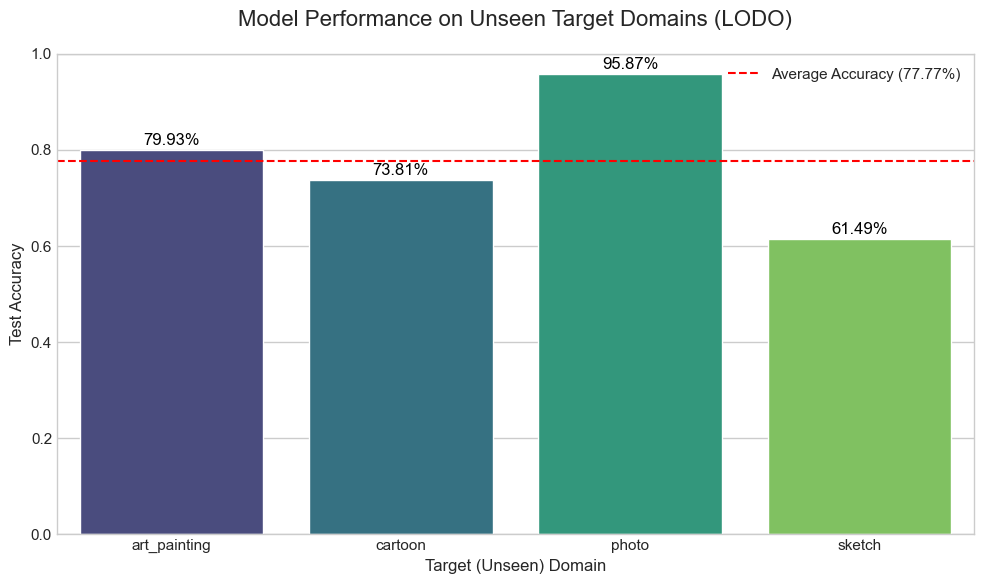


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
evolutionary_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.7993, 0.7381, 0.9587, 0.6149]
}

--- Experiment Complete ---


In [ ]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")

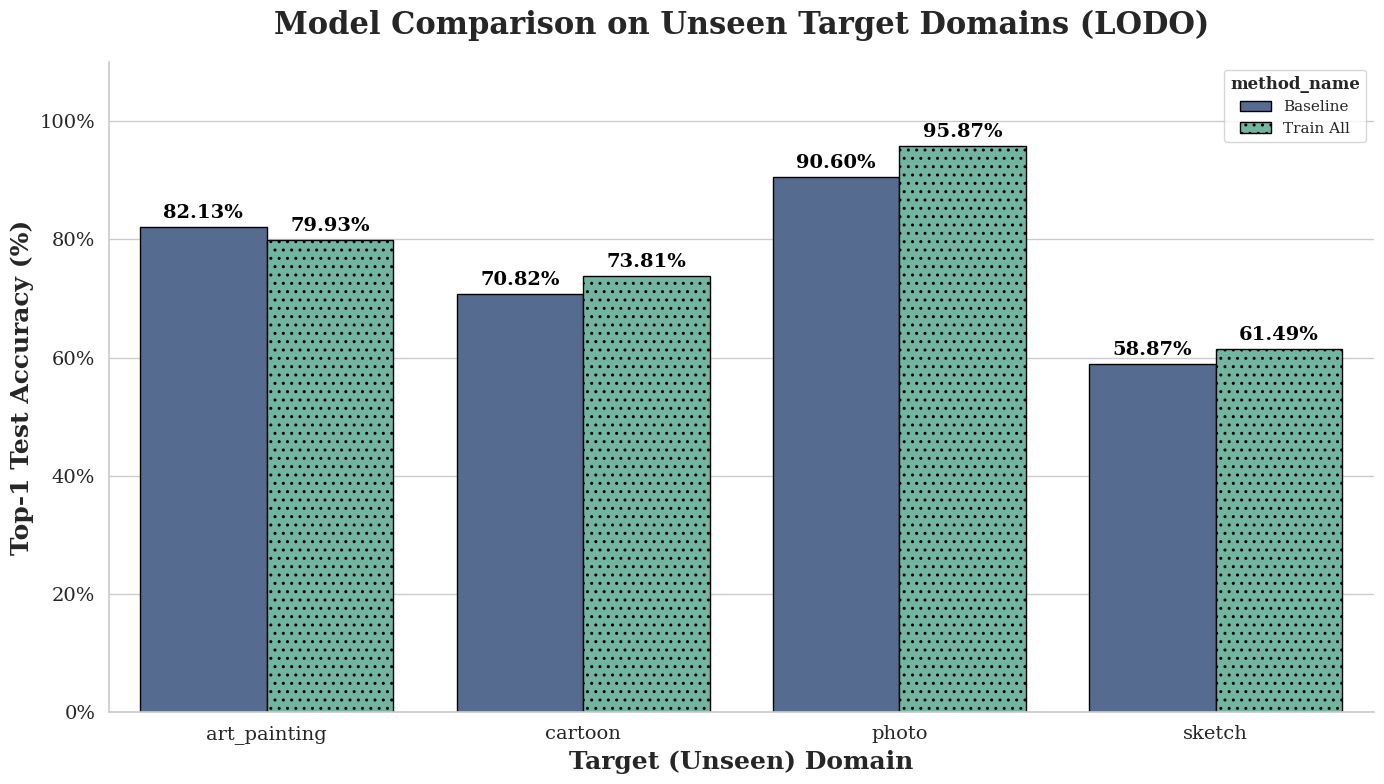


--- Average Performance Summary ---
Average Baseline Accuracy: 75.61%
Average Evolutionary Dropout Accuracy: 77.77%


In [ ]:
# =================================================================================
# SECTION 7: COMPARATIVE ANALYSIS & VISUALIZATION (ACADEMIC STYLE - FINAL FIX)
# =================================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7.1: COMBINE EXPERIMENT RESULTS ---
baseline_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.8213, 0.7082, 0.9060, 0.5887]
}
# Using the results from your successful Option 4 run
evolutionary_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.7993, 0.7381, 0.9587, 0.6149]
}
baseline_df = pd.DataFrame(baseline_results)
baseline_df['method_name'] = 'Baseline'
evolutionary_df = pd.DataFrame(evolutionary_results)
evolutionary_df['method_name'] = 'Train All'
combined_df = pd.concat([baseline_df, evolutionary_df])

# --- 7.2: CREATE THE GROUPED BAR CHART (ROBUST VERSION) ---

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(14, 8))

custom_palette = {'Baseline': '#4B6A9A', 'Train All': '#66C2A5'}

barplot = sns.barplot(
    data=combined_df,
    x='target_domain',
    y='test_accuracy',
    hue='method_name',
    ax=ax,
    palette=custom_palette,
    edgecolor='black'
)

### THE FIX IS HERE ###
# Use the robust 'containers' method to apply patterns correctly.

# ax.containers[0] is the container for the first hue category (Baseline)
# ax.containers[1] is the container for the second hue category (Evolutionary Dropout)

# We want to add a pattern to the second container's bars.
for bar in ax.containers[1]:
    bar.set_hatch('..')

# We also need to apply the pattern to the corresponding legend handle.
# The legend handles are created in the same order.
ax.legend_.legend_handles[1].set_hatch('..')

# --- Add annotations (text on bars) ---
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2%}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --- Final plot styling ---
ax.set_title('Model Comparison on Unseen Target Domains (LODO)', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=18, fontweight='bold')
ax.set_ylabel('Top-1 Test Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

legend = ax.get_legend()
plt.setp(legend.get_title(), fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

# --- Print the final summary table ---
avg_baseline = baseline_df['test_accuracy'].mean()
avg_evolutionary = evolutionary_df['test_accuracy'].mean()
print("\n--- Average Performance Summary ---")
print(f"Average Baseline Accuracy: {avg_baseline:.2%}")
print(f"Average Evolutionary Dropout Accuracy: {avg_evolutionary:.2%}")